In [1]:
from pathlib import Path
import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pyfaidx import Fasta
from meth5 import MetH5File

from benchmark_pycometh.simulation.nanopolish_simulator import OmicsSimlaLoader
from benchmark_pycometh.utils import unions
from nanoepitools.plotting.general_plotting import PlotArchiver, plot_2d_density
from benchmark_pycometh.config import module_config
from nanoepitools.reference_cpgs import ReferenceCpGs

In [2]:
pa = PlotArchiver("simulation", headless=False, config={"plot_archive_dir": "/home/r933r/snajder/nanoepitools_plots/benchmark"})
reference_cpgs = ReferenceCpGs("/home/r933r/data/resource/human/hg19/hg19_no_chr.fa")

def annotate_cpgs(segments):
    segments["CpGs"] = segments.apply(lambda row: set(reference_cpgs.get_CGs(row["chrom"], row["start"], row["end"])), axis=1)

In [5]:
ground_truth_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/wgbs/merged/changepoints.txt"

gt = pd.read_csv(ground_truth_file, sep="\t", names=["chrom", "start", "end", "segment_type", "theta"], dtype={"chrom":str})
annotate_cpgs(gt)


methcp_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/methcp/methcp_highpval_dmr.bed"
methcp_dmrs = pd.read_csv(methcp_dmrs_file, sep="\t", names=["chrom", "start", "end", "nC.valid", "nC", "diffmet_mcp", "cov", "pval"], dtype={"chrom":str})
#methcp_dmrs = methcp_dmrs.loc[(methcp_dmrs["nC.valid"]>10)]
annotate_cpgs(methcp_dmrs)

pycometh_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet.tsv"
pycometh_dmrs = pd.read_csv(pycometh_dmrs_file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
pycometh_dmrs = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.5].copy()
annotate_cpgs(pycometh_dmrs)

pycometh_llr_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet_llrdiff.tsv"
pycometh_llr_dmrs = pd.read_csv(pycometh_llr_dmrs_file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
pycometh_llr_dmrs = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.5].copy()
annotate_cpgs(pycometh_llr_dmrs)

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [6]:
pycometh_fisher_dmrs_file = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/pycometh/diffmet/diffmet_fisher.tsv"
pycometh_fisher_dmrs = pd.read_csv(pycometh_fisher_dmrs_file, sep="\t", dtype={"chromosome":str}).rename({"chromosome":"chrom"}, axis=1)
pycometh_fisher_dmrs = pycometh_fisher_dmrs.loc[pycometh_fisher_dmrs["adj_pvalue"]<0.5].copy()
annotate_cpgs(pycometh_fisher_dmrs)

In [7]:
""" Load the actual, measurable differential methylation in ground truth regions """
simulated_m5 = "/home/r933r/data/projects/nanopore/pycometh_benchmark/simulated/diffmet_merged.m5"
with MetH5File(simulated_m5, "r") as simulated_m5:
    def compute_diffmet(chrom, start, end):
        agg = simulated_m5[chrom].get_values_in_range(start, end).get_llr_site_readgroup_rate("sample")
        diffmet = np.abs(np.nanmean(agg[1][0]) - np.nanmean(agg[2][0]))
        pbar.update(1)
        return diffmet

    with tqdm.tqdm(total=gt.shape[0]) as pbar:
        gt["diffmet"] = gt.apply(lambda row: compute_diffmet(row["chrom"], row["start"], row["end"]), axis=1)
    with tqdm.tqdm(total=methcp_dmrs.shape[0]) as pbar:
        methcp_dmrs["diffmet"] = methcp_dmrs.apply(lambda row: compute_diffmet(row["chrom"], row["start"], row["end"]), axis=1)
    with tqdm.tqdm(total=pycometh_dmrs.shape[0]) as pbar:
        pycometh_dmrs["diffmet"] = pycometh_dmrs.apply(lambda row: compute_diffmet(row["chrom"], row["start"], row["end"]), axis=1)
    with tqdm.tqdm(total=pycometh_llr_dmrs.shape[0]) as pbar:
        pycometh_llr_dmrs["diffmet"] = pycometh_llr_dmrs.apply(lambda row: compute_diffmet(row["chrom"], row["start"], row["end"]), axis=1)
    with tqdm.tqdm(total=pycometh_fisher_dmrs.shape[0]) as pbar:
        pycometh_fisher_dmrs["diffmet"] = pycometh_fisher_dmrs.apply(lambda row: compute_diffmet(row["chrom"], row["start"], row["end"]), axis=1)

100%|██████████████| 12344/12344 [07:47<00:00, 26.43it/s]


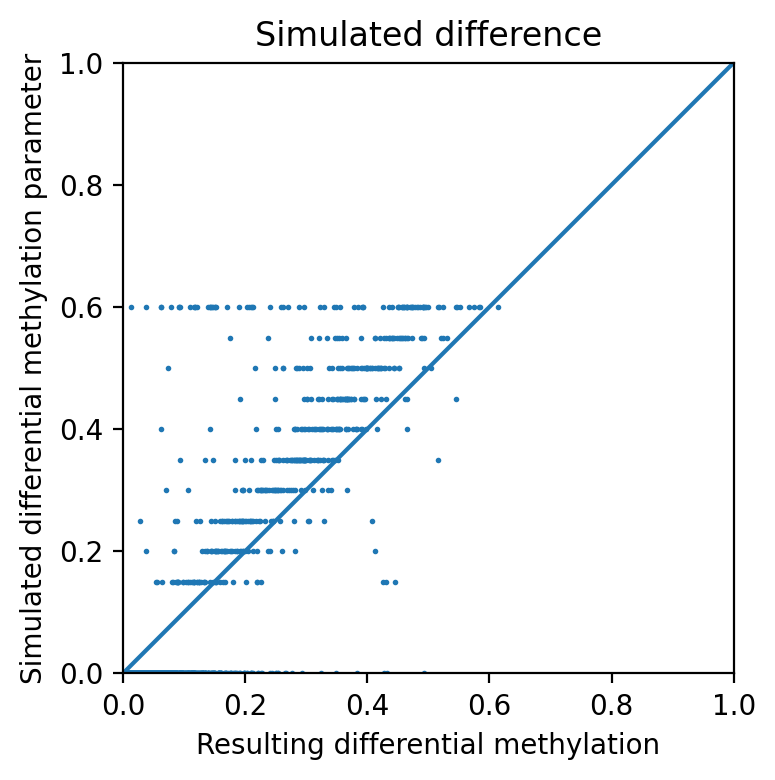

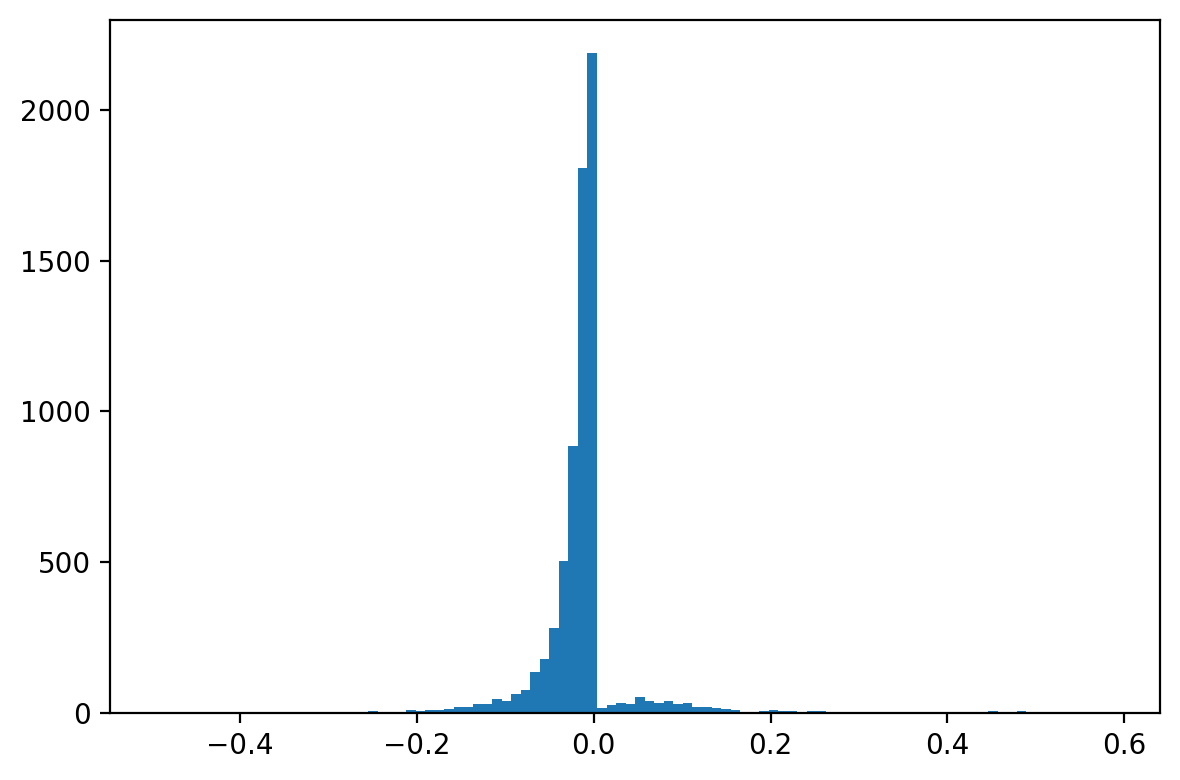

In [8]:
pa.figure()
plt.title("Simulated difference")
plt.scatter(gt["diffmet"], np.abs(gt["theta"]), s=1)
plt.xlabel("Resulting differential methylation")
plt.ylabel("Simulated differential methylation parameter")
plt.plot([0,1], [0,1])
plt.xlim(0,1)
plt.ylim(0,1)
plt.gca().set_aspect("equal")
pa.saveandshow("simulated_difference_vs_parameters")

pa.figure()
plt.hist(np.abs(gt["theta"]) - gt["diffmet"], bins=100)
plt.show()

In [25]:
class ResultComparer:
    def __init__(self, segments):
        self.segments = segments

    def remove_cpgs_not_in_gt(self, gt_key):
        """
        Removing a small number of CpGs that fell through the cracks
        as they are in between block sin the simulation
        """
        allowed_cgs = unions(self.segments[gt_key]["CpGs"])
        for key in self.segments:
            if key == gt_key:
                continue
            self.segments[key]["CpGs"] = self.segments[key]["CpGs"].map(lambda cpgs: cpgs.intersection(allowed_cgs))

    def get(self, key, diffmet_threshold=0.1, below_threshold=False, theta_threshold=0):
        ret = self.segments[key]

        idx = ret["diffmet"].map(lambda x: abs(x)>=diffmet_threshold)
        if theta_threshold != 0:
            idx = idx & ret["theta"].map(lambda x: abs(x) >= theta_threshold)

        if below_threshold:
            idx = ~idx

        return ret.loc[idx]

    def compute_tpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=theta_threshold, theta_threshold=0.1)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_gt_pos = len(gt_pos_cgs)
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        if num_gt_pos == 0:
            return np.nan
        return num_true_pos / num_gt_pos

    def compute_precision(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_pos = self.get(gt, diffmet_threshold=theta_threshold, theta_threshold=0.1)
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        num_pred = len(pred_cgs)

        if num_pred == 0:
            return np.nan
        return num_true_pos / num_pred

    def compute_fpr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=theta_threshold, below_threshold=True, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_gt_neg = len(gt_neg_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_gt_neg == 0:
            return np.nan
        return num_false_pos / num_gt_neg

    def compute_fdr(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])
        gt_neg = self.get(gt, diffmet_threshold=theta_threshold, below_threshold=True, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        if num_pred == 0:
            return np.nan
        return num_false_pos / num_pred

    def compute_discovery_counts(self, gt, pred, diffmet_threshold=0.1, theta_threshold=0.1):
        pred = self.get(pred, diffmet_threshold=diffmet_threshold)
        pred_cgs = unions(pred["CpGs"])

        gt_neg = self.get(gt, diffmet_threshold=theta_threshold, below_threshold=True, theta_threshold=0.1)
        gt_pos = self.get(gt, diffmet_threshold=theta_threshold, theta_threshold=0.1)
        gt_neg_cgs = unions(gt_neg["CpGs"])
        gt_pos_cgs = unions(gt_pos["CpGs"])
        num_pred = len(pred_cgs)
        num_false_pos = len(gt_neg_cgs.intersection(pred_cgs))
        num_true_pos = len(gt_pos_cgs.intersection(pred_cgs))
        return num_false_pos, num_true_pos



In [13]:
def plot_roc(gt, title="", figurename=None):
    tools = {"MethCP":"b", "PycoMeth":"orange", "PycoMeth LLR": "red", "PycoMeth FE": "pink"}
    ps = np.arange(0.001, 0.5, 0.1)
    recall = {t:[] for t in tools}
    precision = {t:[] for t in tools}
    for p in ps:
        filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<p].copy()
        filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<p].copy()
        filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<p].copy()
        filtered_pycometh_fisher = pycometh_fisher_dmrs.loc[pycometh_fisher_dmrs["adj_pvalue"]<p].copy()
        rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr, "PycoMeth FE":filtered_pycometh_fisher})
        rc.remove_cpgs_not_in_gt(gt_key="GT")
        for tool in tools:
            recall[tool].append(rc.compute_tpr("GT", tool))
            precision[tool].append(1-rc.compute_fdr("GT", tool))
    o5_index = np.argmin(np.abs((ps-0.05)))


    fig, (ax1, ax2, ax3) = pa.subplots(1,3, figsize=(8, 3))
    plt.suptitle(title)
    ax1.set_title("Recall")
    for tool, color in tools.items():
        ax1.plot(ps,recall[tool], label=tool, c=color)

    ax2.set_title("Precision")
    for tool, color in tools.items():
        ax2.plot(ps,precision[tool], label=tool, c=color)

    for tool, color in tools.items():
        auc = np.nansum(recall[tool] * np.diff(precision[tool], prepend=0))
        ax3.plot(precision[tool],recall[tool], label=f"{tool} AUC={auc:.2f}", c=color)
        ax3.scatter([precision[tool][o5_index]], [recall[tool][o5_index]], c=color)
    ax3.legend()
    ax3.set_ylabel("Recall")
    ax3.set_xlabel("Precision")

    for ax in ax1, ax2, ax3:
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.set_aspect("equal")
    pa.saveandshow(figurename)


def plot_roc_over_effect_size(gt, title="", figurename=None):
    tools = {"MethCP":"b", "PycoMeth":"orange", "PycoMeth LLR": "red", "PycoMeth FE": "pink"}
    ess = np.arange(0.1, 1.05, 0.025)
    recall = {t:[] for t in tools}
    precision = {t:[] for t in tools}
    f1 = {t:[] for t in tools}
    filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<0.05].copy()
    filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.05].copy()
    filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.05].copy()
    filtered_pycometh_fisher = pycometh_fisher_dmrs.loc[pycometh_fisher_dmrs["adj_pvalue"]<0.05].copy()
    rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr, "PycoMeth FE":filtered_pycometh_fisher})
    rc.remove_cpgs_not_in_gt(gt_key="GT")
    for es in ess:
        for tool in tools:
            r = rc.compute_tpr("GT", tool, theta_threshold=es)
            p = 1-rc.compute_fdr("GT", tool, diffmet_threshold=es)
            f = 2*(p*r)/(p+r)
            recall[tool].append(r)
            precision[tool].append(p)
            f1[tool].append(f)

    fig, (ax1, ax2, ax3) = pa.subplots(1,3, figsize=(8, 4))
    plt.suptitle(title)
    ax1.set_title("Recall")
    for tool, color in tools.items():
        ax1.plot(ess,recall[tool], label=tool, c=color)
    ax1.set_ylabel("Recall")

    ax2.set_title("Precision")
    for tool, color in tools.items():
        ax2.plot(ess,precision[tool], label=tool, c=color)
        ax2.set_ylabel("Precision")

    ax3.set_title("F1-score")
    for tool, color in tools.items():
        ax3.plot(ess,f1[tool], label=tool, c=color)
    ax3.set_ylabel("F1-score")
    ax3.legend()

    for ax in ax1, ax2, ax3:
        ax.set_xlim(0,1)
        ax.set_ylim(0.5,1)
        ax.set_aspect("equal")
        ax.set_xlabel("Effect size")
    pa.saveandshow(figurename)

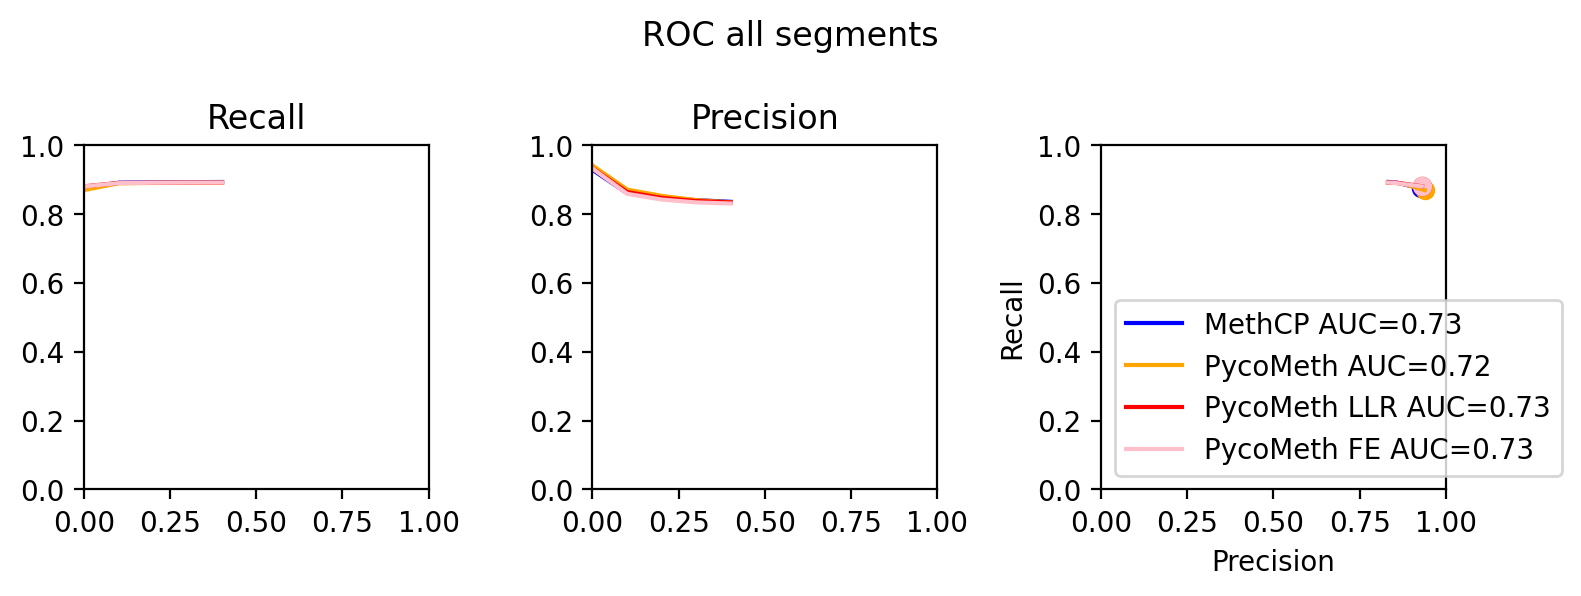

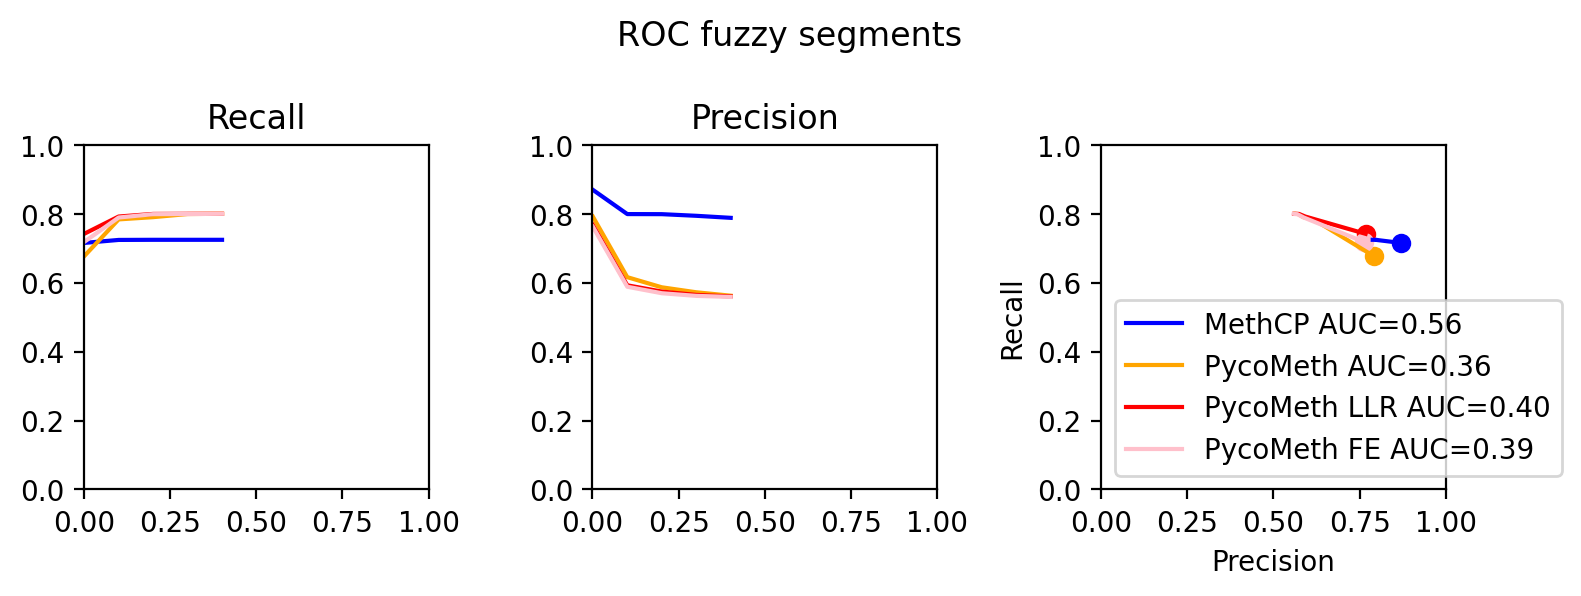

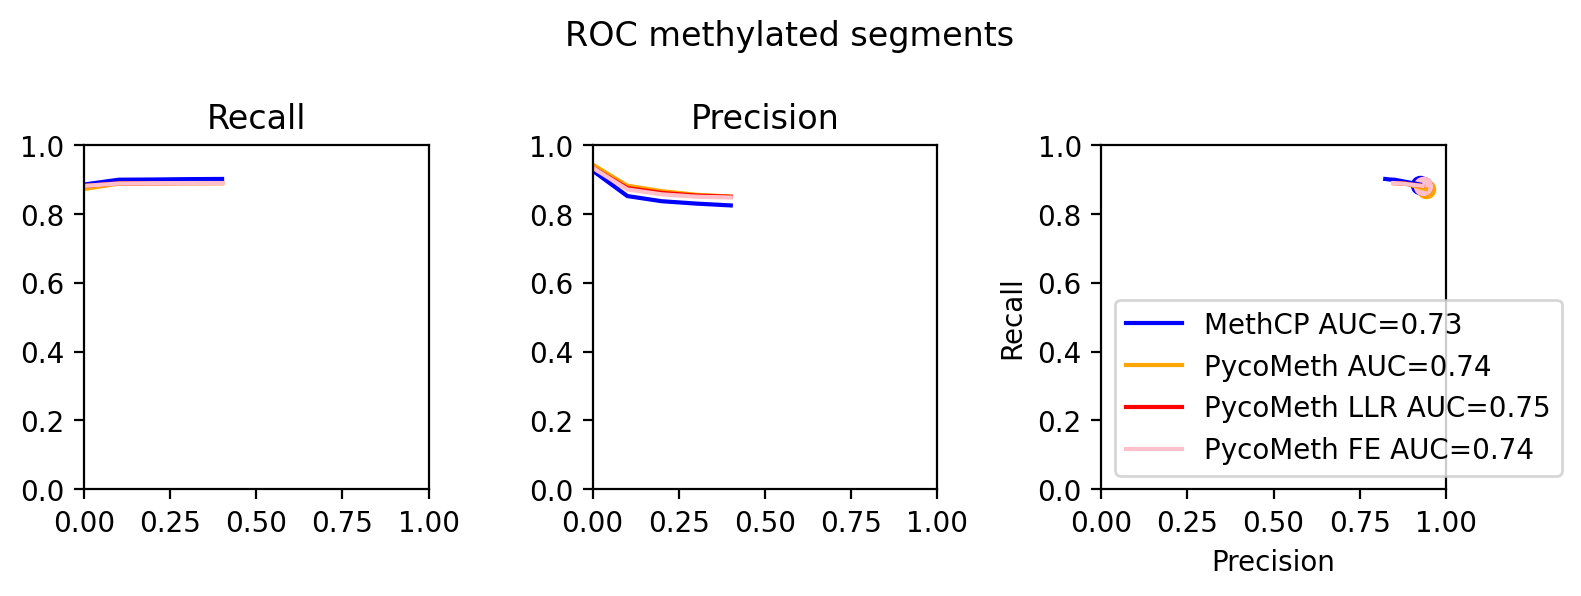

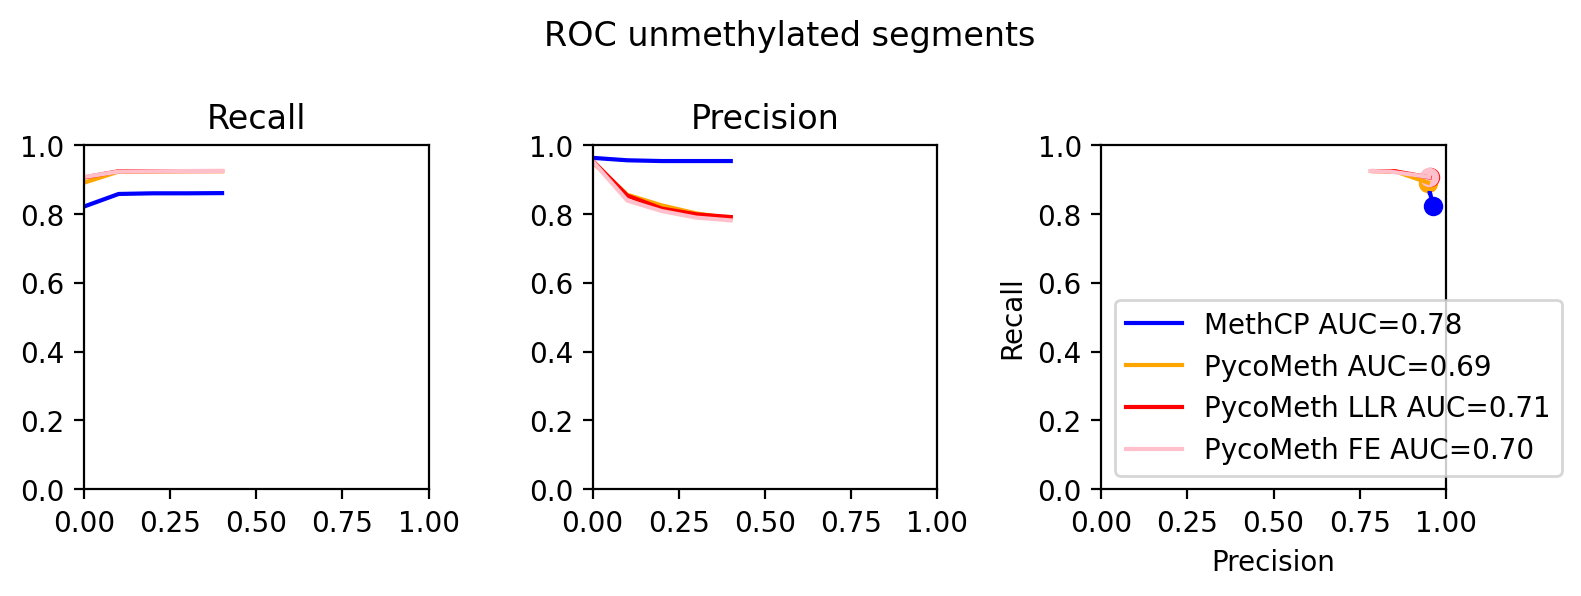

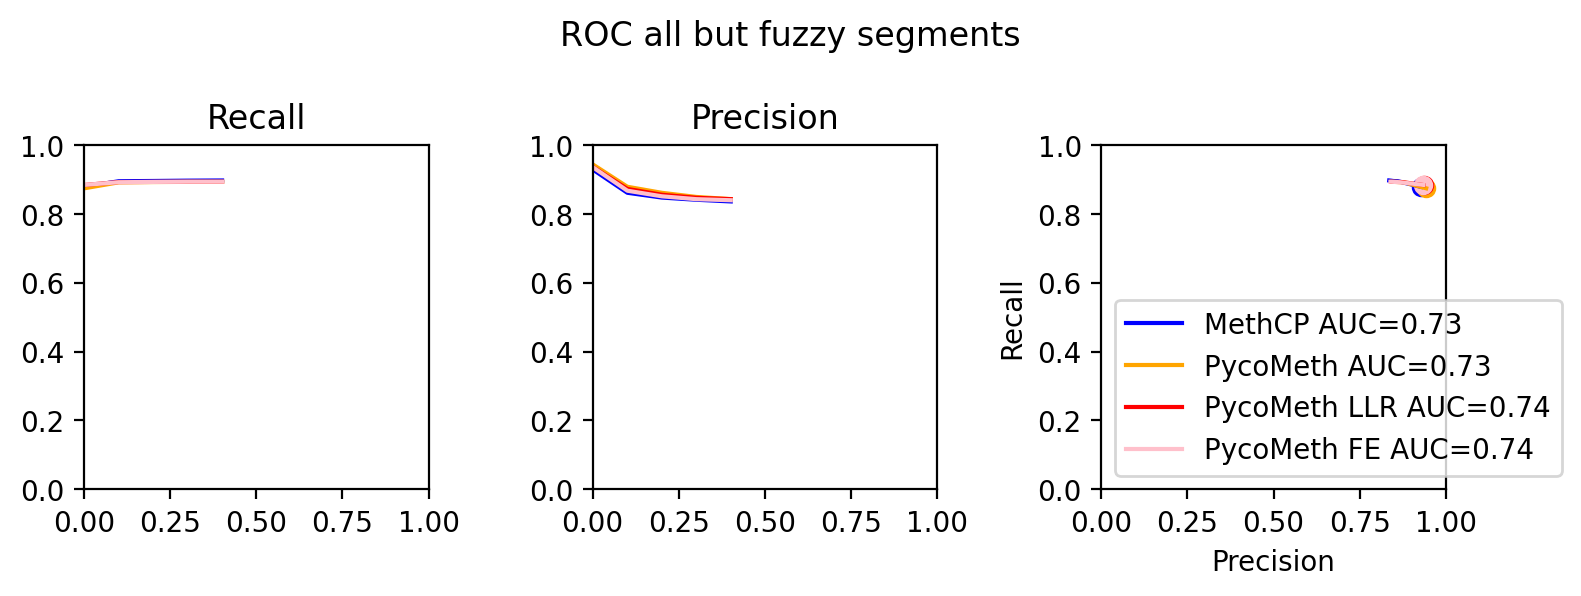

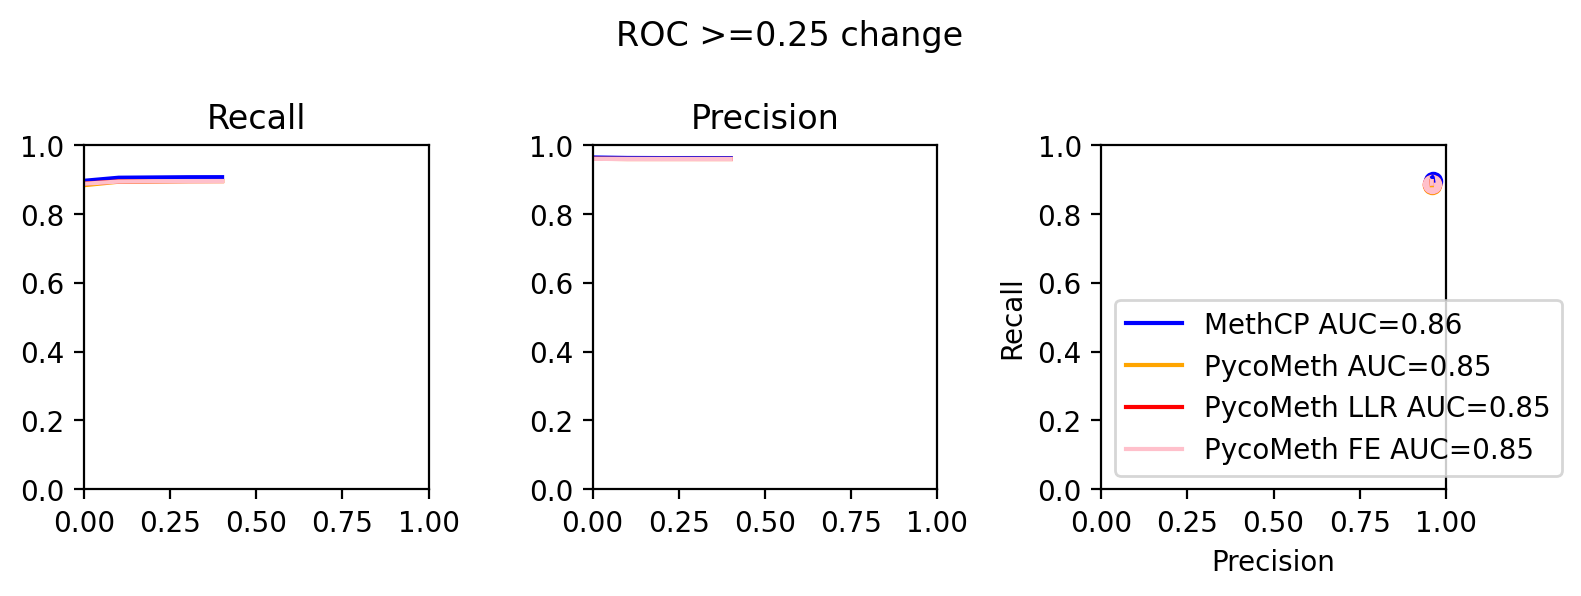

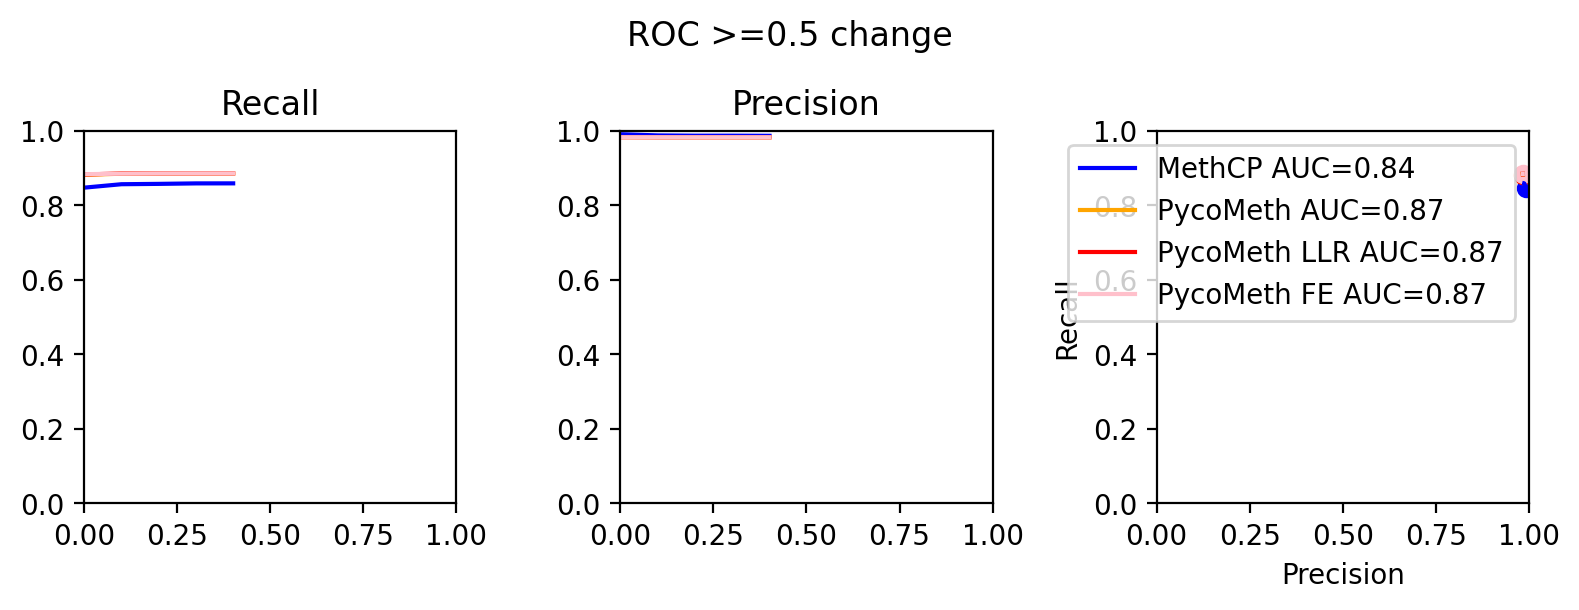

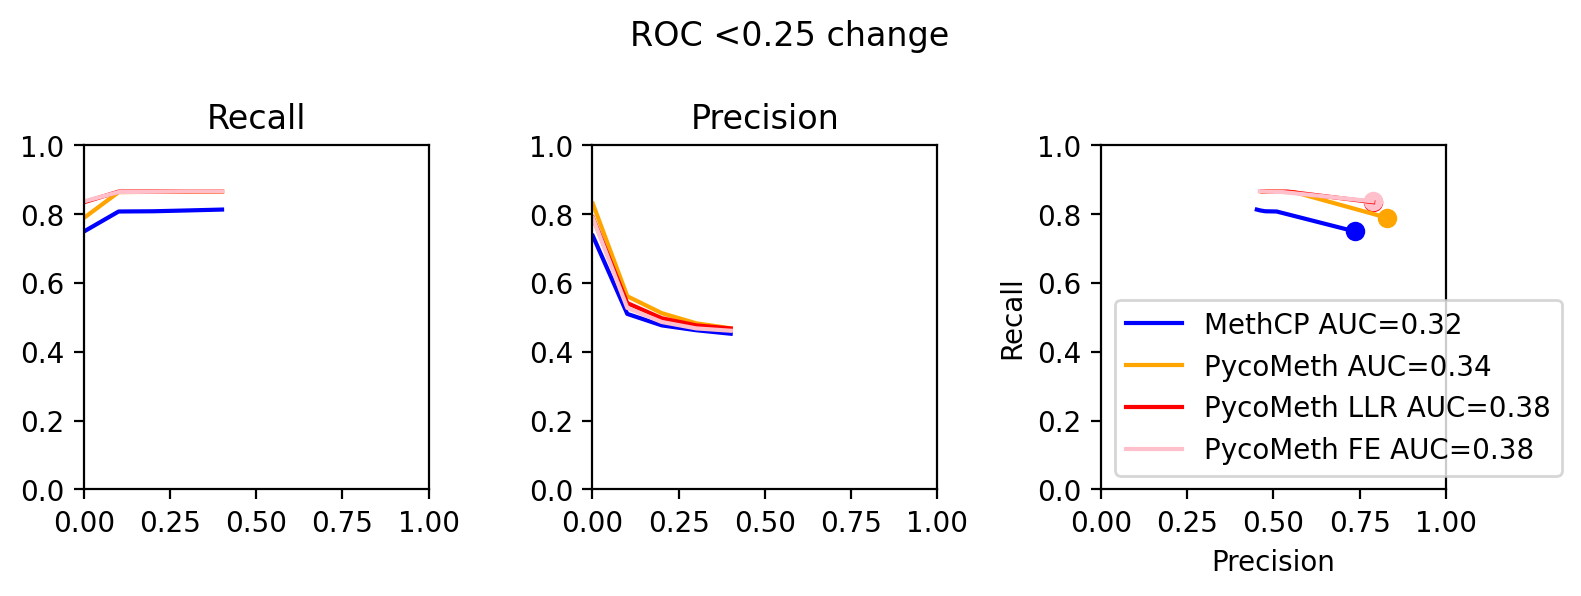

In [11]:
plot_roc(gt, "ROC all segments", "roc_all")
plot_roc(gt.loc[gt["segment_type"]==3].copy(), "ROC fuzzy segments", "roc_fuzzy")
plot_roc(gt.loc[gt["segment_type"]==2].copy(), "ROC methylated segments", "roc_methylated")
plot_roc(gt.loc[gt["segment_type"]==1].copy(), "ROC unmethylated segments", "roc_unmethylated")
plot_roc(gt.loc[gt["segment_type"]!=3].copy(), "ROC all but fuzzy segments", "roc_notfuzzy")
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.25)].copy(), "ROC >=0.25 change", "roc_effect_size_ge0.25")
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) >= 0.5)].copy(), "ROC >=0.5 change", "roc_effect_size_ge0.5")
plot_roc(gt.loc[gt["theta"].map(lambda x: abs(x) < 0.25)].copy(), "ROC <0.25 change", "roc_effect_size_lt0.5")

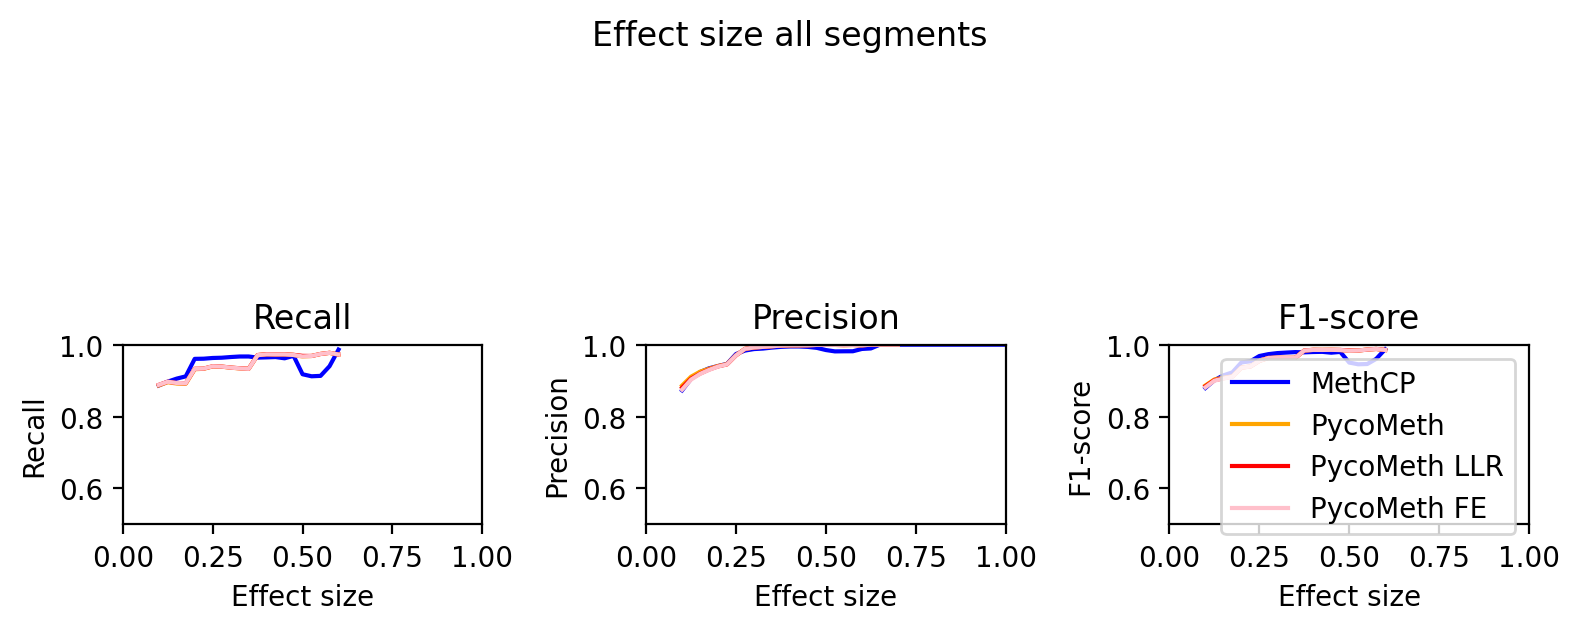

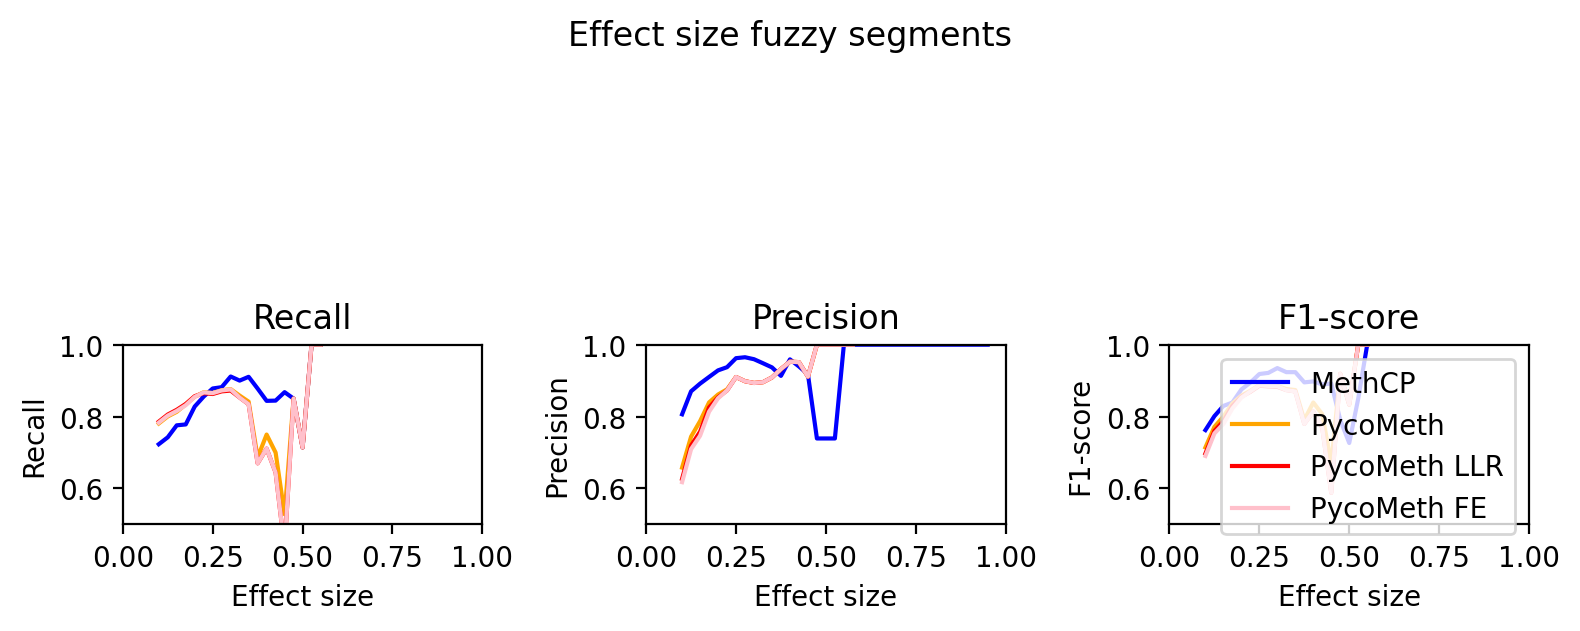

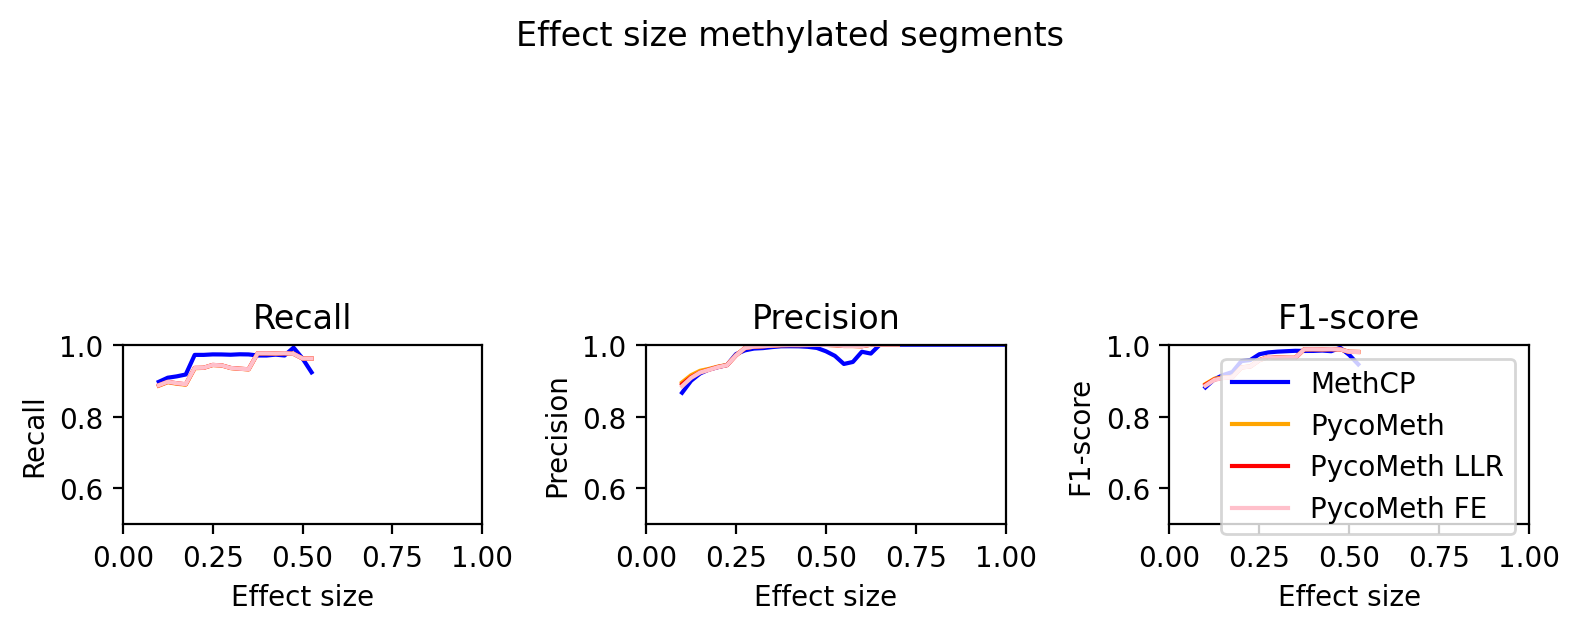

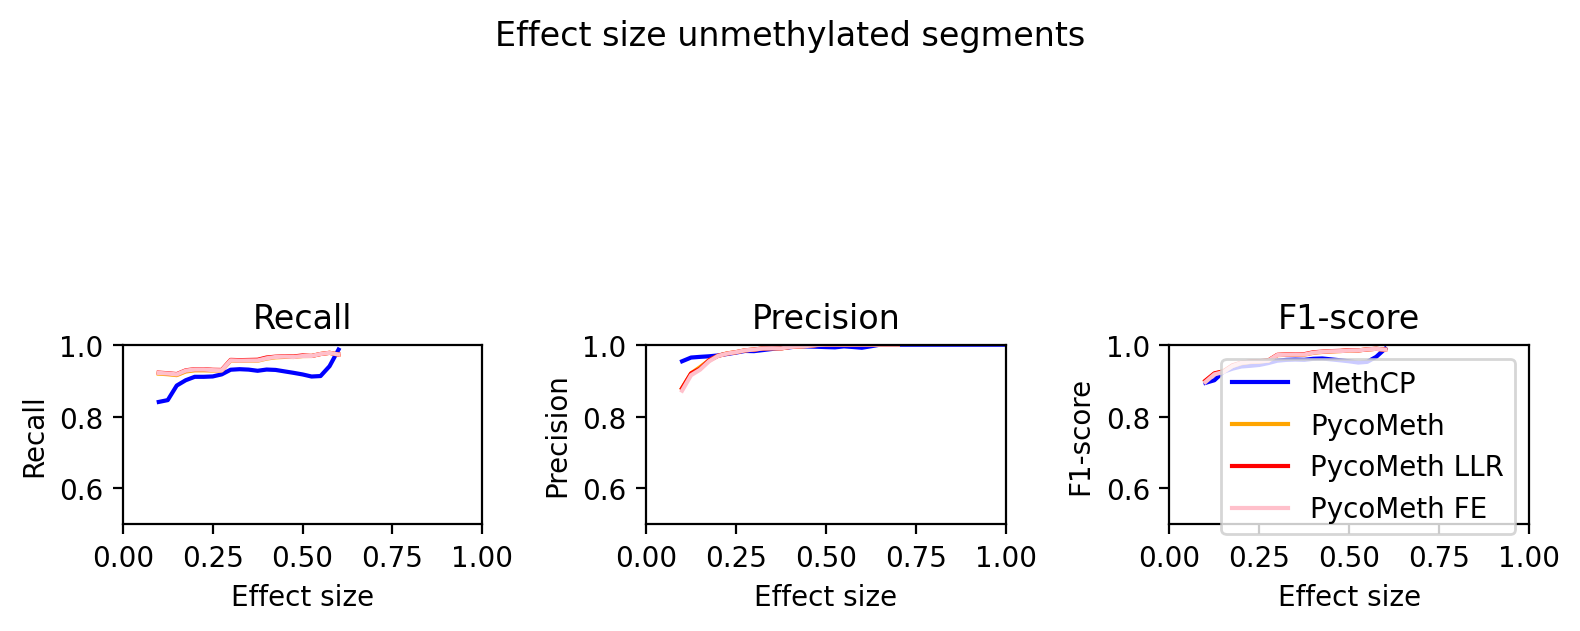

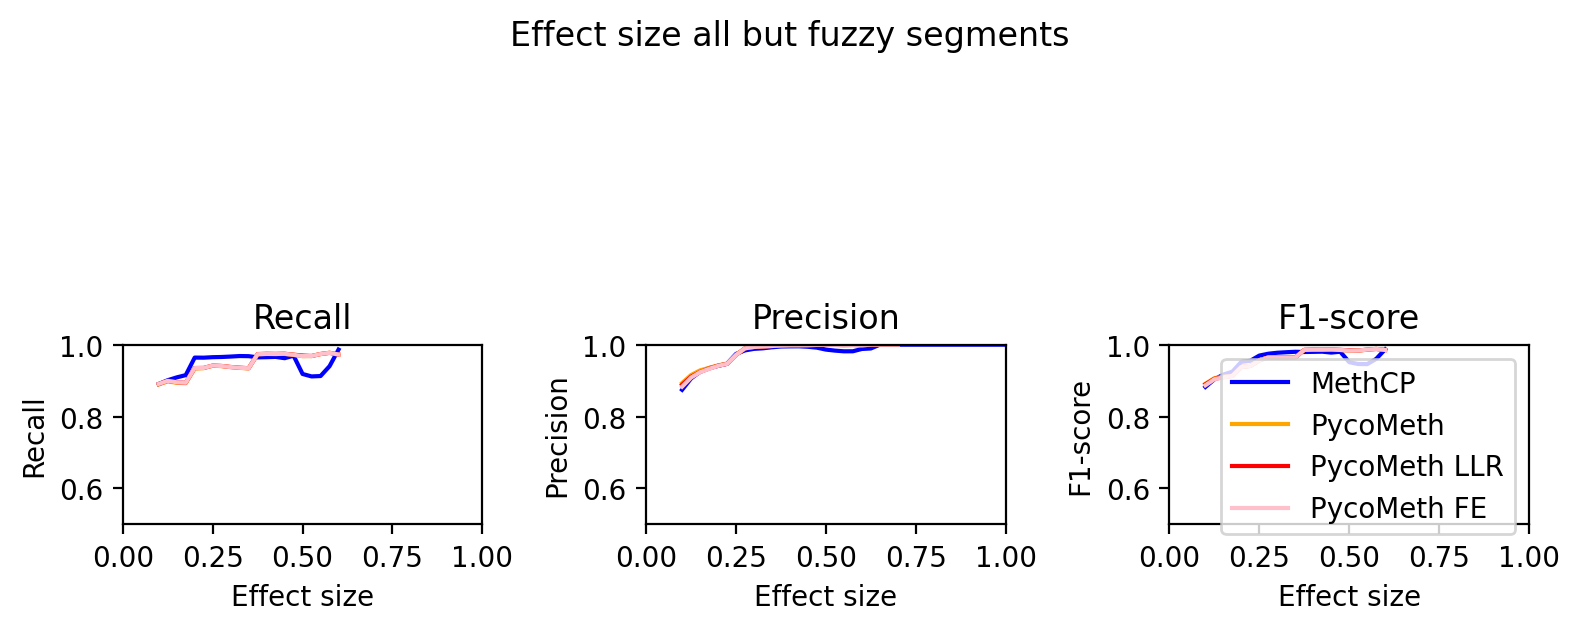

In [14]:
plot_roc_over_effect_size(gt, "Effect size all segments", "roc_effect_size_all")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==3].copy(), "Effect size fuzzy segments", "roc_fuzzy")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==2].copy(), "Effect size methylated segments", "roc_effect_size_methylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]==1].copy(), "Effect size unmethylated segments", "roc_effect_size_unmethylated")
plot_roc_over_effect_size(gt.loc[gt["segment_type"]!=3].copy(), "Effect size all but fuzzy segments", "roc_effect_size_notfuzzy")

In [61]:

filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<0.05].copy()
filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.05].copy()
filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.05].copy()
rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr})
rc.remove_cpgs_not_in_gt(gt_key="GT")

In [ ]:
rc.compute_discovery_counts("GT", "PycoMeth", diffmet_threshold=0.6)

In [ ]:
rc.compute_discovery_counts("GT", "PycoMeth", theta_threshold=0.6)

In [62]:
tool = "PycoMeth"
thresholds = np.arange(0.1, 0.65, 0.05)
fdrs = np.zeros((len(thresholds), len(thresholds)))
for x, tt in enumerate(tqdm.tqdm(thresholds)):
    for y, dt in enumerate(thresholds):
        tp, fp = rc.compute_discovery_counts("GT", tool, theta_threshold=tt, diffmet_threshold=dt)
        if tp+fp == 0:
            fdrs[y,x] = np.nan()
        else:
            fdrs[y,x] = fp / (fp+tp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [01:39<00:00,  9.01s/it]


In [26]:
filtered_methcp = methcp_dmrs.loc[methcp_dmrs["pval"]<0.05].copy()
filtered_pycometh = pycometh_dmrs.loc[pycometh_dmrs["adj_pvalue"]<0.05].copy()
filtered_pycometh_llr = pycometh_llr_dmrs.loc[pycometh_llr_dmrs["adj_pvalue"]<0.05].copy()
filtered_pycometh_fisher = pycometh_fisher_dmrs.loc[pycometh_fisher_dmrs["adj_pvalue"]<0.05].copy()
rc = ResultComparer({"GT":gt, "MethCP": filtered_methcp, "PycoMeth":filtered_pycometh, "PycoMeth LLR":filtered_pycometh_llr, "PycoMeth FE":filtered_pycometh_fisher})
rc.remove_cpgs_not_in_gt(gt_key="GT")

In [27]:
for tool in rc.segments:
    print(tool)
    print(rc.compute_tpr("GT", tool), rc.compute_precision("GT", tool))

GT
1.0 0.9852266080575692
MethCP
0.8864272157307211 0.8729680648447535
PycoMeth
0.886742046037186 0.8863274682394828
PycoMeth LLR
0.8881003139307913 0.8804105509086694
PycoMeth FE
0.8881722751436976 0.8749734155678435
